In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from branchcut.setup import find_residues, create_mask, wrap

from matplotlib.colors import ListedColormap
ccmap = plt.get_cmap('RdYlBu',3)
ncmap = ccmap(range(0,3))
ncmap[0] = np.array([1,0,0,1])
ncmap[2] = np.array([0,0,1,1])
ncmap = ListedColormap(ncmap)

import matplotlib.animation as animation

In [52]:
DIR = '../data/simulated_data_book'
EXAMPLE = 'ISOLA'
SEED = (40,40)
i_bc_store = []
j_bc_store = []

# Functions

In [53]:
def line_animation(i1,j1,i2,j2):
                   
    if abs(i2-i1) >= abs(j2-j1):
        if i1 > i2:
            i1,j1,i2,j2 = i2,j2,i1,j1
        i = np.arange(i1,i2+1)
        j = (j2-j1)/(i2-i1)*(i-i1)+j1
    else:
        if j1 > j2:
            i1,j1,i2,j2 = i2,j2,i1,j1
        j = np.arange(j1,j2+1)
        i = (i2-i1)/(j2-j1)*(j-j1)+i1

    i_bc_store.append(np.ceil(i).astype(int))
    j_bc_store.append(np.ceil(j).astype(int))
    
    return np.ceil(i).astype(int),np.ceil(j).astype(int)

def branch_cut_animation(residue,mask=None,max_box_size=None):

    branch_cuts = np.zeros(residue.shape).astype(bool)
    balanced = np.zeros(residue.shape).astype(bool)
    #found_res = []

    if mask is None:
        mask = np.ones(residue.shape).astype(bool)

    if max_box_size is None:
        max_box_size = np.min(residue.shape)

    # Place branch cut pixels in masked out areas
    branch_cuts[np.invert(mask)] = True

    for i in range(residue.shape[0]):
        for j in range(residue.shape[1]):

            if residue[i,j] and not balanced[i,j]:

                #found_res.append((i,j))

                # Reset active residues  and mark found residue as active
                active = np.zeros(residue.shape).astype(bool)
                active_list = []
                active[i,j] = True
                active_list.append((i,j))
                charge = residue[i,j]

                # Loop over box sizes
                for box_size in range(3,max_box_size+2,2):
                    
                    r = int((box_size-1)/2) # Radius of search (Loop over den her i stedet?)

                    # Loop throuch list of active pixels
                    N = 0
                    while N < len(active_list):

                        ia,ja = active_list[N] # Current active pixel

                        # Loop over box pixels
                        for ib in range(ia-r,ia+r+1):
                            for jb in range(ja-r,ja+r+1):

                                # Detect edges
                                if ib < 0:
                                    branch_cuts[0:ia+1,ja] = True #Top edge
                                    charge = 0

                                elif ib >= residue.shape[0]:
                                    branch_cuts[ia+1:,ja] = True #Bottom edge
                                    charge = 0

                                elif jb < 0:
                                    branch_cuts[ia,0:ja+1] = True #Left edge
                                    charge = 0

                                elif jb >= residue.shape[1]:
                                    branch_cuts[ia,ja+1:] = True #Right edge
                                    charge = 0

                                elif not mask[ib,jb]:
                                    # Place branch cut to edge pixel
                                    i_bc,j_bc = line_animation(ia,ja,ib,jb)
                                    branch_cuts[i_bc,j_bc] = True
                                    charge = 0

                                elif residue[ib,jb] and not active[ib,jb]:

                                    # Mark found residue as active
                                    active[ib,jb] = True
                                    active_list.append((ib,jb))

                                    # Mark as balanced if not already 
                                    if not balanced[ib,jb]:
                                        charge += residue[ib,jb]
                                        balanced[ib,jb] = True

                                    # Place branch cut
                                    i_bc,j_bc = line_animation(ia,ja,ib,jb)
                                    branch_cuts[i_bc,j_bc] = True
                                if not charge:
                                    break
                            if not charge:
                                break                                          
                        N += 1
                        if not charge:
                            break

                    if not charge:
                        break
                
                # If charge still nonzero place branch cut to border (max box size exceeded)
                if charge:
                    closest_edge = np.argmin([i,residue.shape[0]-i,j,residue.shape[1]-j])
                    if closest_edge == 0:
                        branch_cuts[0:ia+1,ja] = True #Top edge
                    elif closest_edge == 1:
                        branch_cuts[ia+1:,ja] = True #Bottom edge
                    elif closest_edge == 2:
                        branch_cuts[ia,0:ja+1] = True #Left edge
                    elif closest_edge == 3:
                        branch_cuts[ia,ja+1:] = True #Right edge

                # Mark residue as balanced
                balanced[i,j] = True
      
    return branch_cuts#, found_res

# Run Code

In [54]:
if EXAMPLE == 'LONGS':
    SHAPE = (458,152)
    FN = 'longs.152x458'
elif EXAMPLE == 'ISOLA':
    SHAPE = (458,157)
    FN = 'isola.157x458'

vars = ['mask','phase','surf']
dtypes = ['uint8','int8','>f4']
data = {}
for i,v in enumerate(vars):
    filename =FN+'.'+v
    data[v]=np.fromfile(os.path.join(DIR,filename),dtype=dtypes[i]).reshape(SHAPE)

data['mask'] = data['mask'].astype(bool)
data['phase_file'] = np.pi * (data['phase'] + 128) / 128 - np.pi # wrapped phase in radians
data['phase_file'][~data['mask']] = np.nan
data['surf'][~data['mask']] = np.nan
data['phase'] = wrap(data['surf'])

residue = find_residues(data['phase'])
residue[residue<-1] = 0
mask=data['mask']
max_box_size = None

BC = branch_cut_animation(residue, mask, max_box_size)

c:\Users\emilt\Documents\Noter\9_RemoteSensing\BranchCut\visualization\..\branchcut\setup\setup.py:104: RuntimeWarning: invalid value encountered in cast
  return _np.round(out).astype(int)


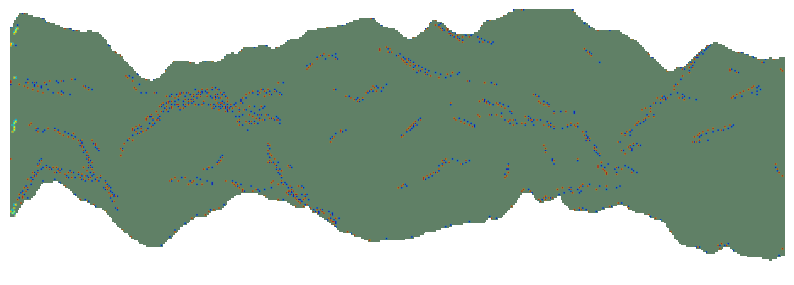

In [55]:
branch_cuts = np.zeros(residue.shape)
branch_cuts[~mask] = np.nan
residueTP = residue.astype(float)
residueTP[~mask] = np.nan

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(residueTP.T, vmin=-1.5, vmax=1.5,cmap='jet')
im = ax.imshow(branch_cuts.T, animated=True,vmin=0,vmax=1,alpha=0.5)
ax.axis('off')

def update(i):
    cval = i*20
    for j in range(20):
        branch_cuts[i_bc_store[cval+j],j_bc_store[cval+j]]=1
    nimage = np.copy(branch_cuts)
    im.set_array(nimage.T)
    return im,

animation_fig = animation.FuncAnimation(fig, update, frames=len(j_bc_store)//20,interval=1, blit=True, repeat_delay=10,)
plt.show()
animation_fig.save("BranchCutIsola.gif")

